In [ ]:
## 1) Comprehension du probleme
* Purpose
We aim to predict the risk of qccident

* Key variable(Cibles and carasteristic)

* Specific Contraints


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score ,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import  mean_squared_error

import xgboost as xgb

# Data Loading

In [12]:
TRAIN_PATH = './dataset/train.csv'
TEST_PATH = './dataset/test.csv'

assert os.path.exists(TRAIN_PATH) , f"This path {TRAIN_PATH} doesnt exist. Make sure it exists"
assert os.path.exists(TEST_PATH) , f"This path {TEST_PATH} doesnt exist. Make sure it exists"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print(f"Train shape:{train.shape}")
print(f"Train shape:{test.shape}")

train.head()

Train shape:(517754, 14)
Train shape:(172585, 13)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [13]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

# Checking the Data Quality


In [14]:
# We try to find null value
print(train.isnull().sum())

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64


In [15]:
print(train.duplicated().sum())


0


In [16]:
print(train.dtypes)

id                          int64
road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
accident_risk             float64
dtype: object


# Univariate

In [17]:
train.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


In [18]:
# Get the data column
COLS = train.columns
TARGET = 'accident_risk'

# Evaluate Class balance
It is useful for checking whether a class is majoritaire. In this case, the model biais can become hight

Distribution of classes accident_risk
0.34    0.03
0.32    0.03
0.37    0.03
0.28    0.03
0.39    0.02
        ... 
0.94    0.00
0.97    0.00
0.96    0.00
0.90    0.00
0.93    0.00
Name: proportion, Length: 98, dtype: float64


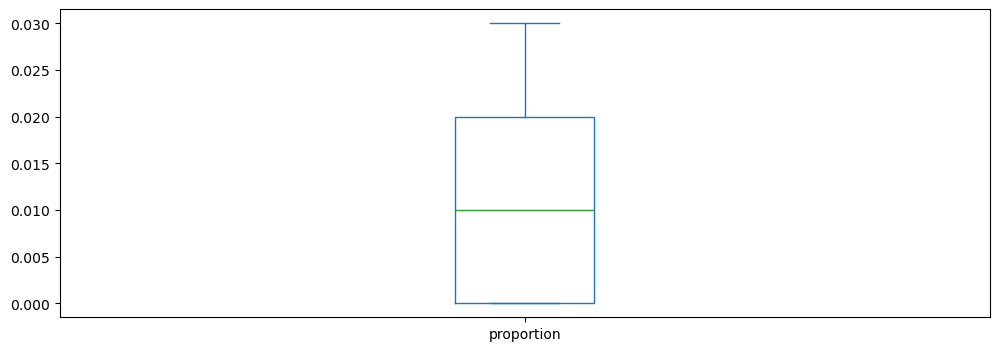

In [19]:
if TARGET in COLS:
    class_dis = train[TARGET].value_counts(normalize=True).round(2)
    print("Distribution of classes",class_dis)

    plt.figure(figsize=(12,4))
    class_dis.sort_values().plot(kind='box')
else:
    print(f"Column {TARGET} doesnt exist. Make sure it exists")

# Detect Outlier

In [ ]:
train.boxplot(
    patch_artist=True,
    flierprops=dict(marker='o',
    markerfacecolor='red',
    markersize=10)
)

plt.title('Outlier')
